# 分析正负先导的发展特征

## 1.加载三维的结果

In [1]:
# 加载对应的python库
import pandas as pd
import numpy as np
three_d_result = pd.read_csv("../two_station_3D/results/3d_win512_cost_cal_yld_chj_dtoa3.6e8_4.0e8.csv")
filtered_3d_result = three_d_result[
    (three_d_result.dlta < 20000) & 
    (three_d_result.yld_start_loc > 3.65e8) & 
    (three_d_result.yld_start_loc < 4e8) & 
    (three_d_result.r_gccs > 0.1) & 
    (abs(three_d_result.R3_value) < 10000) & 
    (three_d_result.x < 6000) & 
    (three_d_result.x > -10000) & 
    (three_d_result.y < 0) & 
    (three_d_result.y > -10000) & 
    (three_d_result.z < 9000) & 
    (three_d_result.z > 500)
]
filtered_3d_result

,yld_start_loc,chj_loc,chj_azimuth,chj_elevation,r_gccs,dlta,R3_value,S_initial_triangulation_1,S_initial_triangulation_2,S_initial_triangulation_3,chi_square_red,cost,dlta_T,x,y,z
0,365619350,399839993,317.550869,57.313533,0.321577,3639.945530,367.695318,-430.268971,-4978.379114,5974.826457,13.864431,0.542739,5996.200361,-420.268972,-4988.379114,5964.826457
3,365622870,399845725,317.821920,57.139538,0.220638,7340.820591,399.838258,-417.475605,-4945.468191,5971.708559,54.449668,0.623490,-5086.158623,-427.475605,-4935.468191,5981.708559
6,365624743,399848809,317.626154,57.077799,0.197513,13411.654633,405.301358,-428.961388,-4949.395614,5967.311289,179.898916,0.641990,-11153.188475,-438.961388,-4939.395614,5977.311289
7,365624967,399845373,318.473390,57.269162,0.221474,4925.156402,344.143098,-397.537922,-4934.466168,5973.027937,24.632977,0.622821,7160.214434,-387.537922,-4944.466168,5963.027937
10,365625426,399850021,317.496975,56.901992,0.237283,16061.693124,402.749403,-441.160263,-4950.690079,5938.102399,257.738667,0.610174,-13802.916159,-451.160263,-4940.690079,5948.102399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11064,399938906,434146257,61.207608,30.971788,0.354787,1307.121340,-328.771762,4607.068203,-6405.771037,1807.513188,2.023199,0.516170,16651.327188,4597.068203,-6415.771037,1797.513188
11065,399939049,434146257,61.207608,30.971788,0.345221,2022.121317,-328.771783,4607.068195,-6405.771040,1807.513186,4.330871,0.523824,17366.327188,4597.068195,-6415.771029,1797.513186
11066,399940685,434146546,19.848992,51.837922,0.381024,12677.806637,1891.055638,2974.126505,-5691.591063,2522.002928,198.999439,0.495181,24100.199877,2984.126470,-5701.591063,2512.002928
11067,399945436,434150789,61.207037,31.277565,0.382344,9923.670331,-44.637233,4248.267105,-6610.530163,1534.297095,97.412650,0.494124,26623.649080,4238.267105,-6620.530163,1524.297095


## 2. 处理三维数据，根据结果的高度，对闪电进行分段

In [148]:
filtered_height_3d_result = filtered_3d_result[
    (filtered_3d_result.z > 5000 ) & (filtered_3d_result.z < 6500 ) &
    (filtered_3d_result.yld_start_loc > 3.816e8 ) & (filtered_3d_result.yld_start_loc < 3.9e8 )
]
filtered_height_3d_result.yld_start_loc.describe()
# filtered_height_3d_result.yld_start_loc

count    8.530000e+02
mean     3.843329e+08
std      1.994035e+06
min      3.816056e+08
25%      3.827143e+08
50%      3.841204e+08
75%      3.855886e+08
max      3.899985e+08
Name: yld_start_loc, dtype: float64

In [47]:
filtered_height_3d_result = filtered_3d_result[
    (filtered_3d_result.z > 3500 ) & (filtered_3d_result.z < 5000 ) &
    (filtered_3d_result.yld_start_loc > 3.66e8 ) & (filtered_3d_result.yld_start_loc < 3.67e8 )
]
filtered_height_3d_result.yld_start_loc.describe()
# filtered_height_3d_result.yld_start_loc

count    2.880000e+02
mean     3.665616e+08
std      2.797073e+05
min      3.660074e+08
25%      3.663346e+08
50%      3.665912e+08
75%      3.668150e+08
max      3.669992e+08
Name: yld_start_loc, dtype: float64

In [51]:
filtered_height_3d_result = filtered_3d_result[
    (filtered_3d_result.z > 2000 ) & (filtered_3d_result.z < 3500 ) &
    (filtered_3d_result.yld_start_loc > 3.67e8 ) & (filtered_3d_result.yld_start_loc < 3.70e8 )
]
filtered_height_3d_result.yld_start_loc.describe()
# filtered_height_3d_result.yld_start_loc

count    9.070000e+02
mean     3.688757e+08
std      6.218531e+05
min      3.672289e+08
25%      3.684327e+08
50%      3.688495e+08
75%      3.693981e+08
max      3.699985e+08
Name: yld_start_loc, dtype: float64

In [55]:
filtered_height_3d_result = filtered_3d_result[
    (filtered_3d_result.z > 500 ) & (filtered_3d_result.z < 2000 ) &
    (filtered_3d_result.yld_start_loc > 3.7e8 ) & (filtered_3d_result.yld_start_loc < 3.72e8 )
]
filtered_height_3d_result.yld_start_loc.describe()
# filtered_height_3d_result.yld_start_loc

count    9.050000e+02
mean     3.708420e+08
std      4.744193e+05
min      3.700021e+08
25%      3.704296e+08
50%      3.707834e+08
75%      3.712209e+08
max      3.719662e+08
Name: yld_start_loc, dtype: float64

## 3. 统计梯级个数(基于二维结果)

In [2]:
# 加载2d定位结果数据
result = pd.read_csv('results/result_yld_3.5e8_4e8_window_512_128_去零飘_滤波_加窗_阈值15_30_80.txt', sep=r'\s+')

# 对2d结果进行过滤筛选
filtered_result = result[
    (abs(result['t123']) < 1) &  # t123的绝对值小于1
    (abs(result['Rcorr']) > 0.3) &  # Rcorr的绝对值大于0.65
    (result['Start_loc'] < 4e8) &  # Start_loc小于4e8
    (result['Start_loc'] > 3.65e8)  
]
filtered_result

,Start_loc,peak,t12,t13,t23,cos_alpha_opt,cos_beta_opt,Azimuth,Elevation,Rcorr,t123
8,365584490,512,35.6,-12.5,-48.2,-0.197293,-0.684594,196.076432,44.564911,0.347082,-0.1
9,365587452,512,20.4,-27.6,-48.1,-0.025744,-0.622050,182.369856,51.495002,0.651742,-0.1
10,365587582,512,20.3,-27.4,-47.8,-0.025895,-0.618279,182.398246,51.769892,0.618671,-0.1
14,365611769,512,19.7,-27.5,-47.8,-0.021704,-0.614658,182.022327,52.045124,0.450302,-0.6
15,365613325,512,20.6,-27.5,-48.5,-0.027856,-0.626630,182.545317,51.152580,0.706949,-0.4
...,...,...,...,...,...,...,...,...,...,...,...
70598,399998225,256,-2.2,-82.2,-79.7,0.367100,-0.886351,157.502151,16.389784,0.447458,0.3
70599,399998441,256,-26.0,-101.3,-76.1,0.615276,-0.747139,140.528244,14.562296,0.584049,-0.8
70600,399998582,256,-25.8,-101.4,-75.7,0.614941,-0.745134,140.467990,14.958218,0.676828,-0.1
70601,399998813,256,-25.9,-101.7,-75.8,0.617019,-0.746092,140.409198,14.493413,0.647456,0.0


## 4. 计算负先导的梯级个数、梯级间隔、梯级步长

### 5500-7000高度

In [161]:
# 选出负先导数据
start_loc = 3.9e8
end_loc = 3.94e8
negative_lead_result = filtered_result[
    (filtered_result.Start_loc >= start_loc) &
    (filtered_result.Start_loc < end_loc)
]
time_diffs = np.diff(negative_lead_result.Start_loc)
max_diff_idx = np.argmax(time_diffs)
corresponding_start_loc = negative_lead_result.Start_loc.iloc[max_diff_idx]
print("最大的间隔位于:",corresponding_start_loc)

# 查看时间间隔大于某阈值的个数

thea = 7000
filtered_negative_time_diffs = time_diffs[ time_diffs > thea]
print(f"时间间隔大于{thea}的个数有：{len(filtered_negative_time_diffs)}")
print(f"负先导 {start_loc}-{end_loc} 阶段的时间间隔分布情况：\n",pd.DataFrame(data=filtered_negative_time_diffs).describe())

最大的间隔位于: 393189811
时间间隔大于7000的个数有：84
负先导 390000000.0-394000000.0 阶段的时间间隔分布情况：
                   0
count     84.000000
mean    9282.571429
std     2593.501918
min     7029.000000
25%     7549.750000
50%     8421.500000
75%     9564.000000
max    19724.000000


In [163]:
from sklearn.cluster import DBSCAN
from scipy import stats
# 计算梯级步长
## Step1: 拿到每个间隔对应的位置范围
filtered_indices = np.where(time_diffs > thea)
filtered_start_loc = negative_lead_result.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
end_locs = filtered_start_loc[1:]    # 去掉第一个元素
# 拼接为元组列表
loc_tuples = list(zip(start_locs, end_locs))

# --- DBSCAN 聚类参数 ---
epsilon = 300  
min_samples = 3

distances = []
# Step2: 三维结果中筛选出对应的结果
for i, loc_tuple in enumerate(loc_tuples):
    # 按时间范围筛选结果
    filtered_loc_3d_result = filtered_3d_result[
        (filtered_3d_result.yld_start_loc > loc_tuple[0] - 1) &
        (filtered_3d_result.yld_start_loc < loc_tuple[1] + 1)
    ]
    if len(filtered_loc_3d_result) > min_samples:
        
        # ====================DBSCAN聚类去噪====================
        points_in_window = filtered_loc_3d_result[['x', 'y', 'z']].values
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points_in_window)
        cluster_labels = db.labels_
        core_samples_labels = cluster_labels[cluster_labels != -1]
        # 找到出现次数最多的簇ID
        main_cluster_id = stats.mode(core_samples_labels).mode
        main_path_mask = (cluster_labels == main_cluster_id)
        if np.sum(main_path_mask) < 2:
            continue
        # 使用掩码从DataFrame中获取主路径的所有数据
        main_path_df = filtered_loc_3d_result[main_path_mask]
        # 对筛选出的主路径点，按时间重新排序
        main_path_sorted_df = main_path_df.sort_values(by='yld_start_loc')
        # 获取并输出主路径的起止位置
        #    .iloc[0] 获取第一行, .iloc[-1] 获取最后一行
        start_position = main_path_sorted_df.iloc[0][['x','y','z']].values
        end_position = main_path_sorted_df.iloc[-1][['x','y','z']].values
        
# Step3: 计算三维距离（步长）
        distance = np.linalg.norm(end_position-start_position)
        distances.append(distance)
    
distances_df = pd.DataFrame(data=distances)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级步长分布情况：\n",distances_df.describe())        

C:\Users\19229\AppData\Local\Temp\ipykernel_112404\2038287661.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_112404\2038287661.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_112404\2038287661.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_112404\2038287661.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sam

负先导 390000000.0-394000000.0 阶段的梯级步长分布情况：
                 0
count   32.000000
mean   111.181523
std     63.179179
min     42.118675
25%     64.104903
50%     89.766378
75%    118.075542
max    289.458478


### 4000-5500高度

In [304]:
# 选出负先导数据
start_loc = 3.94e8
end_loc = 3.965e8
negative_lead_result = filtered_result[
    (filtered_result.Start_loc >= start_loc) &
    (filtered_result.Start_loc < end_loc)
]
time_diffs = np.diff(negative_lead_result.Start_loc)
max_diff_idx = np.argmax(time_diffs)
corresponding_start_loc = negative_lead_result.Start_loc.iloc[max_diff_idx]
print("最大的间隔位于:",corresponding_start_loc)

# 查看时间间隔大于某阈值的个数

thea = 6000
filtered_negative_time_diffs = time_diffs[ time_diffs > thea]
print(f"时间间隔大于{thea}的个数有：{len(filtered_negative_time_diffs)}")
print(f"负先导 {start_loc}-{end_loc} 阶段的时间间隔分布情况：\n",pd.DataFrame(data=filtered_negative_time_diffs).describe())

最大的间隔位于: 394528574
时间间隔大于6000的个数有：72
负先导 394000000.0-396500000.0 阶段的时间间隔分布情况：
                   0
count     72.000000
mean    8668.583333
std     2466.294830
min     6033.000000
25%     7003.000000
50%     7842.500000
75%     9893.000000
max    17017.000000


In [306]:
from sklearn.cluster import DBSCAN
from scipy import stats
# 计算梯级步长
## Step1: 拿到每个间隔对应的位置范围
filtered_indices = np.where(time_diffs > thea)
filtered_start_loc = negative_lead_result.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
end_locs = filtered_start_loc[1:]    # 去掉第一个元素
# 拼接为元组列表
loc_tuples = list(zip(start_locs, end_locs))

# --- DBSCAN 聚类参数 ---
epsilon = 300  
min_samples = 3

distances = []
# Step2: 三维结果中筛选出对应的结果
for i, loc_tuple in enumerate(loc_tuples):
    # 按时间范围筛选结果
    filtered_loc_3d_result = filtered_3d_result[
        (filtered_3d_result.yld_start_loc > loc_tuple[0] - 1) &
        (filtered_3d_result.yld_start_loc < loc_tuple[1] + 1)
    ]
    if len(filtered_loc_3d_result) > min_samples:
        
        # ====================DBSCAN聚类去噪====================
        points_in_window = filtered_loc_3d_result[['x', 'y', 'z']].values
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points_in_window)
        cluster_labels = db.labels_
        core_samples_labels = cluster_labels[cluster_labels != -1]
        # 找到出现次数最多的簇ID
        main_cluster_id = stats.mode(core_samples_labels).mode
        main_path_mask = (cluster_labels == main_cluster_id)
        if np.sum(main_path_mask) < 2:
            continue
        # 使用掩码从DataFrame中获取主路径的所有数据
        main_path_df = filtered_loc_3d_result[main_path_mask]
        # 对筛选出的主路径点，按时间重新排序
        main_path_sorted_df = main_path_df.sort_values(by='yld_start_loc')
        # 获取并输出主路径的起止位置
        #    .iloc[0] 获取第一行, .iloc[-1] 获取最后一行
        start_position = main_path_sorted_df.iloc[0][['x','y','z']].values
        end_position = main_path_sorted_df.iloc[-1][['x','y','z']].values
        
# Step3: 计算三维距离（步长）
        distance = np.linalg.norm(end_position-start_position)
        distances.append(distance)
    

distances_df = pd.DataFrame(data=distances)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级步长分布情况：\n",distances_df.describe())
        

C:\Users\19229\AppData\Local\Temp\ipykernel_33516\2279937337.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_33516\2279937337.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_33516\2279937337.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_33516\2279937337.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample 

负先导 394000000.0-396500000.0 阶段的梯级步长分布情况：
                 0
count   26.000000
mean   130.012783
std     80.194046
min     43.654846
25%     59.422754
50%    107.940293
75%    183.104362
max    336.238342


### 2500-4000 高度

In [146]:
# 选出负先导数据
start_loc = 3.965e8
end_loc = 3.98e8
negative_lead_result = filtered_result[
    (filtered_result.Start_loc >= start_loc) &
    (filtered_result.Start_loc < end_loc)
]
time_diffs = np.diff(negative_lead_result.Start_loc)
max_diff_idx = np.argmax(time_diffs)
corresponding_start_loc = negative_lead_result.Start_loc.iloc[max_diff_idx]
print("最大的间隔位于:",corresponding_start_loc)

# 查看时间间隔大于某阈值的个数

thea = 3000
filtered_negative_time_diffs = time_diffs[ time_diffs > thea]
print(f"时间间隔大于{thea}的个数有：{len(filtered_negative_time_diffs)}")
print(f"负先导 {start_loc}-{end_loc} 阶段的时间间隔分布情况：\n",pd.DataFrame(data=filtered_negative_time_diffs).describe())

最大的间隔位于: 396642080
时间间隔大于3000的个数有：67
负先导 396500000.0-398000000.0 阶段的时间间隔分布情况：
                  0
count    67.000000
mean   4403.000000
std    1199.145921
min    3016.000000
25%    3596.000000
50%    4077.000000
75%    4981.500000
max    8460.000000


In [312]:
from sklearn.cluster import DBSCAN
from scipy import stats
# 计算梯级步长
## Step1: 拿到每个间隔对应的位置范围
filtered_indices = np.where(time_diffs > thea)
filtered_start_loc = negative_lead_result.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
end_locs = filtered_start_loc[1:]    # 去掉第一个元素
# 拼接为元组列表
loc_tuples = list(zip(start_locs, end_locs))

# --- DBSCAN 聚类参数 ---
epsilon = 200  
min_samples = 3

distances = []
# Step2: 三维结果中筛选出对应的结果
for i, loc_tuple in enumerate(loc_tuples):
    # 按时间范围筛选结果
    filtered_loc_3d_result = filtered_3d_result[
        (filtered_3d_result.yld_start_loc > loc_tuple[0] - 1) &
        (filtered_3d_result.yld_start_loc < loc_tuple[1] + 1)
    ]
    if len(filtered_loc_3d_result) > min_samples:
        
        # ====================DBSCAN聚类去噪====================
        points_in_window = filtered_loc_3d_result[['x', 'y', 'z']].values
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points_in_window)
        cluster_labels = db.labels_
        core_samples_labels = cluster_labels[cluster_labels != -1]
        # 找到出现次数最多的簇ID
        main_cluster_id = stats.mode(core_samples_labels).mode
        main_path_mask = (cluster_labels == main_cluster_id)
        if np.sum(main_path_mask) < 2:
            continue
        # 使用掩码从DataFrame中获取主路径的所有数据
        main_path_df = filtered_loc_3d_result[main_path_mask]
        # 对筛选出的主路径点，按时间重新排序
        main_path_sorted_df = main_path_df.sort_values(by='yld_start_loc')
        # 获取并输出主路径的起止位置
        #    .iloc[0] 获取第一行, .iloc[-1] 获取最后一行
        start_position = main_path_sorted_df.iloc[0][['x','y','z']].values
        end_position = main_path_sorted_df.iloc[-1][['x','y','z']].values
        
# Step3: 计算三维距离（步长）
        distance = np.linalg.norm(end_position-start_position)
        distances.append(distance)
    

distances_df = pd.DataFrame(data=distances)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级步长分布情况：\n",distances_df.describe())
        

C:\Users\19229\AppData\Local\Temp\ipykernel_33516\4229713236.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_33516\4229713236.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_33516\4229713236.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_33516\4229713236.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample 

负先导 396500000.0-398000000.0 阶段的梯级步长分布情况：
                 0
count   28.000000
mean   144.056596
std     82.778563
min     11.287030
25%     81.586063
50%    142.964007
75%    203.259484
max    302.754497


### 1000-2500 高度

In [145]:
# 选出负先导数据
start_loc = 3.989e8
end_loc = 4e8
negative_lead_result = filtered_result[
    (filtered_result.Start_loc >= start_loc) &
    (filtered_result.Start_loc < end_loc)
]
time_diffs = np.diff(negative_lead_result.Start_loc)
max_diff_idx = np.argmax(time_diffs)
corresponding_start_loc = negative_lead_result.Start_loc.iloc[max_diff_idx]
print("最大的间隔位于:",corresponding_start_loc)

# 查看时间间隔大于某阈值的个数

thea = 2000
filtered_negative_time_diffs = time_diffs[ time_diffs > thea]
print(f"时间间隔大于{thea}的个数有：{len(filtered_negative_time_diffs)}")
print(f"负先导 {start_loc}-{end_loc} 阶段的时间间隔分布情况：\n",pd.DataFrame(data=filtered_negative_time_diffs).describe())

最大的间隔位于: 399540746
时间间隔大于6000的个数有：0
负先导 398900000.0-400000000.0 阶段的时间间隔分布情况：
          0
count  0.0
mean   NaN
std    NaN
min    NaN
25%    NaN
50%    NaN
75%    NaN
max    NaN


In [315]:
from sklearn.cluster import DBSCAN
from scipy import stats
# 计算梯级步长
## Step1: 拿到每个间隔对应的位置范围
filtered_indices = np.where(time_diffs > thea)
filtered_start_loc = negative_lead_result.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
end_locs = filtered_start_loc[1:]    # 去掉第一个元素
# 拼接为元组列表
loc_tuples = list(zip(start_locs, end_locs))

# --- DBSCAN 聚类参数 ---
epsilon = 300  
min_samples = 3

distances = []
# Step2: 三维结果中筛选出对应的结果
for i, loc_tuple in enumerate(loc_tuples):
    # 按时间范围筛选结果
    filtered_loc_3d_result = filtered_3d_result[
        (filtered_3d_result.yld_start_loc > loc_tuple[0] - 1) &
        (filtered_3d_result.yld_start_loc < loc_tuple[1] + 1)
    ]
    if len(filtered_loc_3d_result) > min_samples:
        
        # ====================DBSCAN聚类去噪====================
        points_in_window = filtered_loc_3d_result[['x', 'y', 'z']].values
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points_in_window)
        cluster_labels = db.labels_
        core_samples_labels = cluster_labels[cluster_labels != -1]
        # 找到出现次数最多的簇ID
        main_cluster_id = stats.mode(core_samples_labels).mode
        main_path_mask = (cluster_labels == main_cluster_id)
        if np.sum(main_path_mask) < 2:
            continue
        # 使用掩码从DataFrame中获取主路径的所有数据
        main_path_df = filtered_loc_3d_result[main_path_mask]
        # 对筛选出的主路径点，按时间重新排序
        main_path_sorted_df = main_path_df.sort_values(by='yld_start_loc')
        # 获取并输出主路径的起止位置
        #    .iloc[0] 获取第一行, .iloc[-1] 获取最后一行
        start_position = main_path_sorted_df.iloc[0][['x','y','z']].values
        end_position = main_path_sorted_df.iloc[-1][['x','y','z']].values
        
# Step3: 计算三维距离（步长）
        distance = np.linalg.norm(end_position-start_position)
        distances.append(distance)
    

distances_df = pd.DataFrame(data=distances)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级步长分布情况：\n",distances_df.describe())
        

负先导 398900000.0-400000000.0 阶段的梯级步长分布情况：
                 0
count   13.000000
mean   178.832180
std    120.979255
min     17.329304
25%     85.100499
50%    181.580345
75%    295.590608
max    355.157391


C:\Users\19229\AppData\Local\Temp\ipykernel_33516\2279937337.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_33516\2279937337.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_33516\2279937337.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_33516\2279937337.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample 

### 3.2 计算负先导的间隔

### 500-2000

In [91]:
# 选出正先导数据
start_loc = 3.7e8
end_loc = 3.72e8
negative_lead_result = filtered_result[
    (filtered_result.Start_loc >= start_loc) &
    (filtered_result.Start_loc < end_loc)
]
time_diffs = np.diff(negative_lead_result.Start_loc)
max_diff_idx = np.argmax(time_diffs)
corresponding_start_loc = negative_lead_result.Start_loc.iloc[max_diff_idx]
print("最大的间隔位于:",corresponding_start_loc)

# 查看时间间隔大于某阈值的个数

thea = 4000
filtered_positive_time_diffs = time_diffs[ time_diffs > thea]
print(f"时间间隔大于{thea}的个数有：{len(filtered_positive_time_diffs)}")
print(f"负先导 {start_loc}-{end_loc} 阶段的时间间隔分布情况：\n",pd.DataFrame(data=filtered_positive_time_diffs).describe())

最大的间隔位于: 370105899
时间间隔大于4000的个数有：4
负先导 370000000.0-372000000.0 阶段的时间间隔分布情况：
                  0
count     4.000000
mean   4411.500000
std     496.948354
min    4079.000000
25%    4109.000000
50%    4212.500000
75%    4515.000000
max    5142.000000


In [94]:
from sklearn.cluster import DBSCAN
from scipy import stats
# 计算梯级步长
## Step1: 拿到每个间隔对应的位置范围
filtered_indices = np.where(time_diffs > thea)
filtered_start_loc = negative_lead_result.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
end_locs = filtered_start_loc[1:]    # 去掉第一个元素
# 拼接为元组列表
loc_tuples = list(zip(start_locs, end_locs))

# --- DBSCAN 聚类参数 ---
epsilon = 50
min_samples = 2
durations = []
distances = []
# Step2: 三维结果中筛选出对应的结果
for i, loc_tuple in enumerate(loc_tuples):
    # 按时间范围筛选结果
    filtered_loc_3d_result = filtered_3d_result[
        (filtered_3d_result.yld_start_loc > loc_tuple[0] - 1) &
        (filtered_3d_result.yld_start_loc < loc_tuple[1] + 1)
    ]
    if len(filtered_loc_3d_result) > min_samples:
        
        # ====================DBSCAN聚类去噪====================
        points_in_window = filtered_loc_3d_result[['x', 'y', 'z']].values
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points_in_window)
        cluster_labels = db.labels_
        core_samples_labels = cluster_labels[cluster_labels != -1]
        # 找到出现次数最多的簇ID
        main_cluster_id = stats.mode(core_samples_labels).mode
        main_path_mask = (cluster_labels == main_cluster_id)
        if np.sum(main_path_mask) < 2:
            continue
        # 使用掩码从DataFrame中获取主路径的所有数据
        main_path_df = filtered_loc_3d_result[main_path_mask]
        # 对筛选出的主路径点，按时间重新排序
        main_path_sorted_df = main_path_df.sort_values(by='yld_start_loc')
        # 获取并输出主路径的起止位置
        #    .iloc[0] 获取第一行, .iloc[-1] 获取最后一行
        start_position = main_path_sorted_df.iloc[0][['x','y','z']].values
        end_position = main_path_sorted_df.iloc[-1][['x','y','z']].values
        
# Step3: 计算三维距离（步长）
        distance = np.linalg.norm(end_position-start_position)
        distances.append(distance)
        durations.append((loc_tuple[1]-loc_tuple[0])*5/1e3)


distances_df = pd.DataFrame(data=distances)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级步长分布情况：\n",distances_df.describe())
durations_df = pd.DataFrame(data=durations)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级持续时间分布情况：\n",durations_df.describe())
        

负先导 370000000.0-372000000.0 阶段的梯级步长分布情况：
                0
count   2.000000
mean   36.962047
std     6.416232
min    32.425086
25%    34.693566
50%    36.962047
75%    39.230527
max    41.499008
负先导 370000000.0-372000000.0 阶段的梯级持续时间分布情况：
                 0
count    2.000000
mean   103.925000
std     42.426407
min     73.925000
25%     88.925000
50%    103.925000
75%    118.925000
max    133.925000


### 2000-3500

In [114]:
# 选出正先导数据
start_loc = 3.67e8
end_loc = 3.7e8
negative_lead_result = filtered_result[
    (filtered_result.Start_loc >= start_loc) &
    (filtered_result.Start_loc < end_loc)
]
time_diffs = np.diff(negative_lead_result.Start_loc)
max_diff_idx = np.argmax(time_diffs)
corresponding_start_loc = negative_lead_result.Start_loc.iloc[max_diff_idx]
print("最大的间隔位于:",corresponding_start_loc)

# 查看时间间隔大于某阈值的个数

thea = 4000
filtered_positive_time_diffs = time_diffs[ time_diffs > thea]
filtered_positive_time_diffs = filtered_positive_time_diffs*5/1e3
print(f"时间间隔大于{thea}的个数有：{len(filtered_positive_time_diffs)}")
print(f"负先导 {start_loc}-{end_loc} 阶段的时间间隔分布情况：\n",pd.DataFrame(data=filtered_positive_time_diffs).describe())

最大的间隔位于: 368074204
时间间隔大于4000的个数有：46
负先导 367000000.0-370000000.0 阶段的时间间隔分布情况：
                0
count  46.000000
mean   25.810652
std     5.754519
min    20.280000
25%    21.623750
50%    24.060000
75%    28.601250
max    47.610000


In [117]:
from sklearn.cluster import DBSCAN
from scipy import stats
# 计算梯级步长
## Step1: 拿到每个间隔对应的位置范围
filtered_indices = np.where(time_diffs > thea)
filtered_start_loc = negative_lead_result.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
end_locs = filtered_start_loc[1:]    # 去掉第一个元素
# 拼接为元组列表
loc_tuples = list(zip(start_locs, end_locs))

# --- DBSCAN 聚类参数 ---
epsilon = 50
min_samples = 2
durations = []
distances = []
# Step2: 三维结果中筛选出对应的结果
for i, loc_tuple in enumerate(loc_tuples):
    # 按时间范围筛选结果
    filtered_loc_3d_result = filtered_3d_result[
        (filtered_3d_result.yld_start_loc > loc_tuple[0] - 1) &
        (filtered_3d_result.yld_start_loc < loc_tuple[1] + 1)
    ]
    if len(filtered_loc_3d_result) > min_samples:
        
        # ====================DBSCAN聚类去噪====================
        points_in_window = filtered_loc_3d_result[['x', 'y', 'z']].values
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points_in_window)
        cluster_labels = db.labels_
        core_samples_labels = cluster_labels[cluster_labels != -1]
        # 找到出现次数最多的簇ID
        main_cluster_id = stats.mode(core_samples_labels).mode
        main_path_mask = (cluster_labels == main_cluster_id)
        if np.sum(main_path_mask) < 2:
            continue
        # 使用掩码从DataFrame中获取主路径的所有数据
        main_path_df = filtered_loc_3d_result[main_path_mask]
        # 对筛选出的主路径点，按时间重新排序
        main_path_sorted_df = main_path_df.sort_values(by='yld_start_loc')
        # 获取并输出主路径的起止位置
        #    .iloc[0] 获取第一行, .iloc[-1] 获取最后一行
        start_position = main_path_sorted_df.iloc[0][['x','y','z']].values
        end_position = main_path_sorted_df.iloc[-1][['x','y','z']].values
        
# Step3: 计算三维距离（步长）
        distance = np.linalg.norm(end_position-start_position)
        distances.append(distance)
        durations.append((loc_tuple[1]-loc_tuple[0])*5/1e3)


distances_df = pd.DataFrame(data=distances)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级步长分布情况：\n",distances_df.describe())
durations_df = pd.DataFrame(data=durations)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级持续时间分布情况：\n",durations_df.describe())
        

负先导 367000000.0-370000000.0 阶段的梯级步长分布情况：
                   0
count  3.200000e+01
mean   4.013852e+01
std    3.871529e+01
min    1.544590e-07
25%    1.472223e+01
50%    2.395195e+01
75%    6.306083e+01
max    1.755115e+02
负先导 367000000.0-370000000.0 阶段的梯级持续时间分布情况：
                  0
count    32.000000
mean    422.265469
std     495.331787
min      30.960000
25%     134.998750
50%     297.437500
75%     427.400000
max    2353.910000


C:\Users\19229\AppData\Local\Temp\ipykernel_32980\2630391186.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_32980\2630391186.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_32980\2630391186.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode
C:\Users\19229\AppData\Local\Temp\ipykernel_32980\2630391186.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample 

### 3500-5000

In [139]:
# 选出正先导数据
start_loc = 3.66e8
end_loc = 3.67e8
negative_lead_result = filtered_result[
    (filtered_result.Start_loc >= start_loc) &
    (filtered_result.Start_loc < end_loc)
]
time_diffs = np.diff(negative_lead_result.Start_loc)
max_diff_idx = np.argmax(time_diffs)
corresponding_start_loc = negative_lead_result.Start_loc.iloc[max_diff_idx]
print("最大的间隔位于:",corresponding_start_loc)

# 查看时间间隔大于某阈值的个数

thea = 4500
filtered_positive_time_diffs = time_diffs[ time_diffs > thea]
filtered_positive_time_diffs = filtered_positive_time_diffs*5/1e3
print(f"时间间隔大于{thea}的个数有：{len(filtered_positive_time_diffs)}")
print(f"负先导 {start_loc}-{end_loc} 阶段的时间间隔分布情况：\n",pd.DataFrame(data=filtered_positive_time_diffs).describe())

最大的间隔位于: 366513067
时间间隔大于4500的个数有：4
负先导 366000000.0-367000000.0 阶段的时间间隔分布情况：
                0
count   4.000000
mean   28.110000
std     2.216179
min    26.205000
25%    26.550000
50%    27.572500
75%    29.132500
max    31.090000


In [140]:
from sklearn.cluster import DBSCAN
from scipy import stats
# 计算梯级步长
## Step1: 拿到每个间隔对应的位置范围
filtered_indices = np.where(time_diffs > thea)
filtered_start_loc = negative_lead_result.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
end_locs = filtered_start_loc[1:]    # 去掉第一个元素
# 拼接为元组列表
loc_tuples = list(zip(start_locs, end_locs))

# --- DBSCAN 聚类参数 ---
epsilon = 80  
min_samples = 2
durations = []
distances = []
# Step2: 三维结果中筛选出对应的结果
for i, loc_tuple in enumerate(loc_tuples):
    # 按时间范围筛选结果
    filtered_loc_3d_result = filtered_3d_result[
        (filtered_3d_result.yld_start_loc > loc_tuple[0] - 1) &
        (filtered_3d_result.yld_start_loc < loc_tuple[1] + 1)
    ]
    if len(filtered_loc_3d_result) > min_samples:
        
        # ====================DBSCAN聚类去噪====================
        points_in_window = filtered_loc_3d_result[['x', 'y', 'z']].values
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points_in_window)
        cluster_labels = db.labels_
        core_samples_labels = cluster_labels[cluster_labels != -1]
        # 找到出现次数最多的簇ID
        main_cluster_id = stats.mode(core_samples_labels).mode
        main_path_mask = (cluster_labels == main_cluster_id)
        if np.sum(main_path_mask) < 2:
            continue
        # 使用掩码从DataFrame中获取主路径的所有数据
        main_path_df = filtered_loc_3d_result[main_path_mask]
        # 对筛选出的主路径点，按时间重新排序
        main_path_sorted_df = main_path_df.sort_values(by='yld_start_loc')
        # 获取并输出主路径的起止位置
        #    .iloc[0] 获取第一行, .iloc[-1] 获取最后一行
        start_position = main_path_sorted_df.iloc[0][['x','y','z']].values
        end_position = main_path_sorted_df.iloc[-1][['x','y','z']].values
        
# Step3: 计算三维距离（步长）
        distance = np.linalg.norm(end_position-start_position)
        distances.append(distance)
        durations.append((loc_tuple[1]-loc_tuple[0])*5/1e3)


distances_df = pd.DataFrame(data=distances)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级步长分布情况：\n",distances_df.describe())
durations_df = pd.DataFrame(data=durations)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级持续时间分布情况：\n",durations_df.describe())
        

负先导 366000000.0-367000000.0 阶段的梯级步长分布情况：
                0
count   3.000000
mean   52.811594
std     9.656633
min    42.245465
25%    48.627478
50%    55.009491
75%    58.094658
max    61.179825
负先导 366000000.0-367000000.0 阶段的梯级持续时间分布情况：
                 0
count    3.000000
mean   475.503333
std     62.463082
min    409.620000
25%    446.322500
50%    483.025000
75%    508.445000
max    533.865000


### 5000-6500

In [130]:
# 选出正先导数据
start_loc = 3.65e8
end_loc = 3.66e8
negative_lead_result = filtered_result[
    (filtered_result.Start_loc >= start_loc) &
    (filtered_result.Start_loc < end_loc)
]
time_diffs = np.diff(negative_lead_result.Start_loc)
max_diff_idx = np.argmax(time_diffs)
corresponding_start_loc = negative_lead_result.Start_loc.iloc[max_diff_idx]
print("最大的间隔位于:",corresponding_start_loc)

# 查看时间间隔大于某阈值的个数

thea = 3000
filtered_positive_time_diffs = time_diffs[ time_diffs > thea]
filtered_positive_time_diffs = filtered_positive_time_diffs*5/1e3
print(f"时间间隔大于{thea}的个数有：{len(filtered_positive_time_diffs)}")
print(f"负先导 {start_loc}-{end_loc} 阶段的时间间隔分布情况：\n",pd.DataFrame(data=filtered_positive_time_diffs).describe())

最大的间隔位于: 365587582
时间间隔大于3000的个数有：5
负先导 365000000.0-366000000.0 阶段的时间间隔分布情况：
                 0
count    5.000000
mean    41.106000
std     49.117255
min     15.380000
25%     15.970000
50%     21.020000
75%     24.445000
max    128.715000


In [136]:
from sklearn.cluster import DBSCAN
from scipy import stats
# 计算梯级步长
## Step1: 拿到每个间隔对应的位置范围
filtered_indices = np.where(time_diffs > thea)
filtered_start_loc = negative_lead_result.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
end_locs = filtered_start_loc[1:]    # 去掉第一个元素
# 拼接为元组列表
loc_tuples = list(zip(start_locs, end_locs))

# --- DBSCAN 聚类参数 ---
epsilon = 27
min_samples = 2
durations = []
distances = []
# Step2: 三维结果中筛选出对应的结果
for i, loc_tuple in enumerate(loc_tuples):
    # 按时间范围筛选结果
    filtered_loc_3d_result = filtered_3d_result[
        (filtered_3d_result.yld_start_loc > loc_tuple[0] - 1) &
        (filtered_3d_result.yld_start_loc < loc_tuple[1] + 1)
    ]
    if len(filtered_loc_3d_result) > min_samples:
        
        # ====================DBSCAN聚类去噪====================
        points_in_window = filtered_loc_3d_result[['x', 'y', 'z']].values
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points_in_window)
        cluster_labels = db.labels_
        core_samples_labels = cluster_labels[cluster_labels != -1]
        # 找到出现次数最多的簇ID
        main_cluster_id = stats.mode(core_samples_labels).mode
        main_path_mask = (cluster_labels == main_cluster_id)
        if np.sum(main_path_mask) < 2:
            continue
        # 使用掩码从DataFrame中获取主路径的所有数据
        main_path_df = filtered_loc_3d_result[main_path_mask]
        # 对筛选出的主路径点，按时间重新排序
        main_path_sorted_df = main_path_df.sort_values(by='yld_start_loc')
        # 获取并输出主路径的起止位置
        #    .iloc[0] 获取第一行, .iloc[-1] 获取最后一行
        start_position = main_path_sorted_df.iloc[0][['x','y','z']].values
        end_position = main_path_sorted_df.iloc[-1][['x','y','z']].values
        
# Step3: 计算三维距离（步长）
        distance = np.linalg.norm(end_position-start_position)
        distances.append(distance)
        durations.append((loc_tuple[1]-loc_tuple[0])*5/1e3)


distances_df = pd.DataFrame(data=distances)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级步长分布情况：\n",distances_df.describe())
durations_df = pd.DataFrame(data=durations)
print(f"负先导 {start_loc}-{end_loc} 阶段的梯级持续时间分布情况：\n",durations_df.describe())
        

负先导 365000000.0-366000000.0 阶段的梯级步长分布情况：
                 0
count    4.000000
mean    84.252270
std    106.881655
min     21.234068
25%     25.616010
50%     35.954196
75%     94.590456
max    243.866622
负先导 365000000.0-366000000.0 阶段的梯级持续时间分布情况：
                  0
count     4.000000
mean    505.155000
std     480.340627
min     241.275000
25%     243.112500
50%     277.670000
75%     539.712500
max    1224.005000


## 4. 计算正先导的间隔、步长

In [16]:
# 选出正先导数据
start_loc = 3.816e8
end_loc = 3.89e8
positive_lead_result = filtered_result[
    (filtered_result.Start_loc >= start_loc) &
    (filtered_result.Start_loc < end_loc)
]
time_diffs = np.diff(positive_lead_result.Start_loc)
max_diff_idx = np.argmax(time_diffs)
corresponding_start_loc = positive_lead_result.Start_loc.iloc[max_diff_idx]
print("最大的间隔位于:",corresponding_start_loc)

# 查看时间间隔大于某阈值的个数

thea = 20000
filtered_positive_time_diffs = time_diffs[ time_diffs > thea]
filtered_positive_time_diffs = filtered_positive_time_diffs*5/1e3
print(f"时间间隔大于{thea}的个数有：{len(filtered_positive_time_diffs)}")
print(f"正先导 {start_loc}-{end_loc} 阶段的时间间隔分布情况：\n",pd.DataFrame(data=filtered_positive_time_diffs).describe())

最大的间隔位于: 388630045
时间间隔大于20000的个数有：10
正先导 381600000.0-389000000.0 阶段的时间间隔分布情况：
                 0
count   10.000000
mean   122.936000
std     22.652188
min    101.890000
25%    109.366250
50%    115.432500
75%    125.817500
max    174.740000


In [27]:
from sklearn.cluster import DBSCAN
from scipy import stats
# 计算梯级步长
## Step1: 拿到每个间隔对应的位置范围
filtered_indices = np.where(time_diffs > thea)
filtered_start_loc = positive_lead_result.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
end_locs = filtered_start_loc[1:]    # 去掉第一个元素
# 拼接为元组列表
loc_tuples = list(zip(start_locs, end_locs))

# --- DBSCAN 聚类参数 ---
epsilon = 80
min_samples = 3
durations = []
distances = []
# Step2: 三维结果中筛选出对应的结果
for i, loc_tuple in enumerate(loc_tuples):
    # 按时间范围筛选结果
    filtered_loc_3d_result = filtered_3d_result[
        (filtered_3d_result.yld_start_loc > loc_tuple[0] - 1) &
        (filtered_3d_result.yld_start_loc < loc_tuple[1] + 1)
    ]
    if len(filtered_loc_3d_result) > min_samples:
        
        # ====================DBSCAN聚类去噪====================
        points_in_window = filtered_loc_3d_result[['x', 'y', 'z']].values
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points_in_window)
        cluster_labels = db.labels_
        core_samples_labels = cluster_labels[cluster_labels != -1]
        # 找到出现次数最多的簇ID
        main_cluster_id = stats.mode(core_samples_labels).mode
        main_path_mask = (cluster_labels == main_cluster_id)
        if np.sum(main_path_mask) < 2:
            continue
        # 使用掩码从DataFrame中获取主路径的所有数据
        main_path_df = filtered_loc_3d_result[main_path_mask]
        # 对筛选出的主路径点，按时间重新排序
        main_path_sorted_df = main_path_df.sort_values(by='yld_start_loc')
        # 获取并输出主路径的起止位置
        #    .iloc[0] 获取第一行, .iloc[-1] 获取最后一行
        start_position = main_path_sorted_df.iloc[0][['x','y','z']].values
        end_position = main_path_sorted_df.iloc[-1][['x','y','z']].values
        
# Step3: 计算三维距离（步长）
        distance = np.linalg.norm(end_position-start_position)
        distances.append(distance)
        durations.append((loc_tuple[1]-loc_tuple[0])*5/1e3)


distances_df = pd.DataFrame(data=distances)
print(f"正先导 {start_loc}-{end_loc} 阶段的梯级步长分布情况：\n",distances_df.describe())
durations_df = pd.DataFrame(data=durations)
print(f"正先导 {start_loc}-{end_loc} 阶段的梯级持续时间分布情况：\n",durations_df.describe())
        

正先导 381600000.0-389000000.0 阶段的梯级步长分布情况：
                 0
count    3.000000
mean   164.033070
std    173.396648
min     61.253617
25%     63.934434
50%     66.615250
75%    215.422796
max    364.230342
正先导 381600000.0-389000000.0 阶段的梯级持续时间分布情况：
                   0
count      3.000000
mean    7838.823333
std    11790.416550
min      550.840000
25%     1037.422500
50%     1524.005000
75%    11482.815000
max    21441.625000


C:\Users\19229\AppData\Local\Temp\ipykernel_30344\3045093591.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  main_cluster_id = stats.mode(core_samples_labels).mode


## 5.绘制相关图

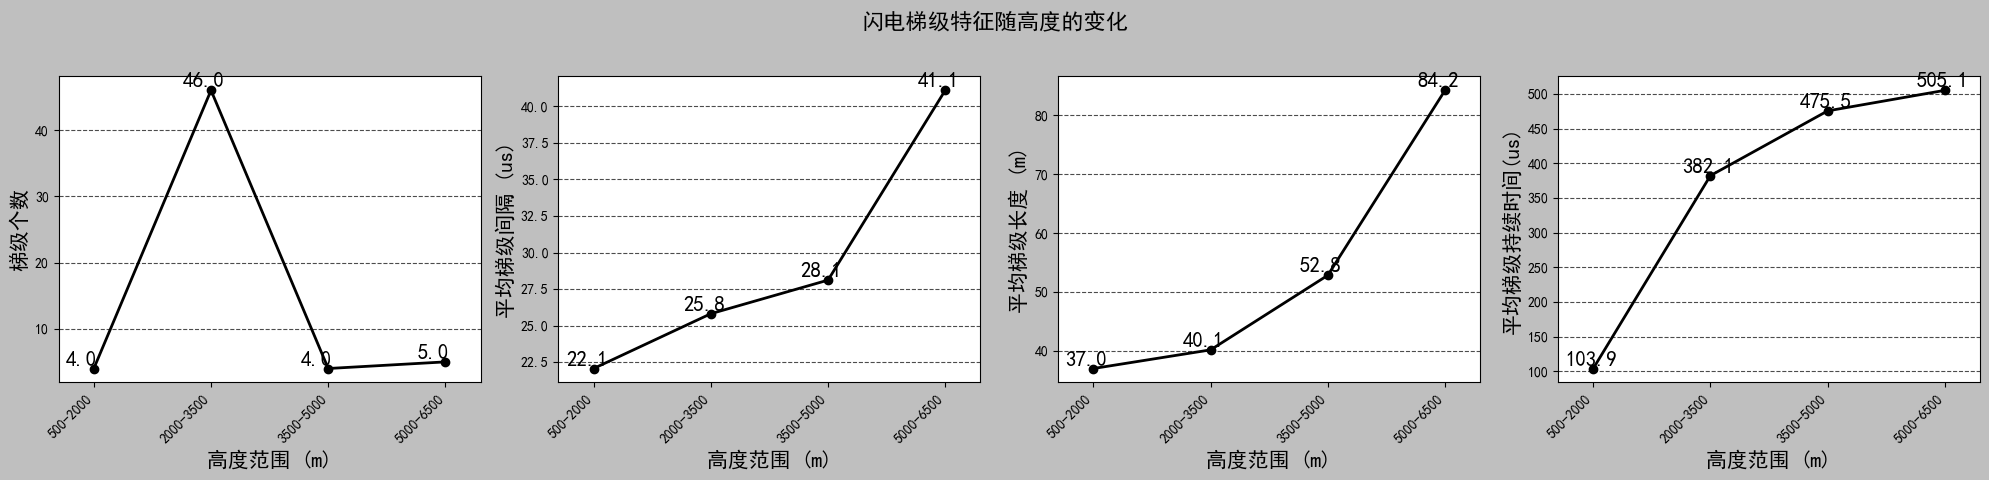

黑白风格的折线图已生成并保存为 'lightning_characteristics_lineplot.png'


In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import re
import numpy as np

# 基础配置（中文+黑白色）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('grayscale')

# 数据读取与处理（同原代码）
data_string = """高度范围（m）,起始结束位置,持续时间（ms）,梯级个数,梯级间隔（us）,梯级持续时间（us）,梯级长度(m)
"500-2000","3.7e8-3.72e8",10,4,"22.06 (20.39-25.71)","103.92 (73.92-133.92)","36.96 (32.42-41.50)"
"2000-3500","3.67e8-3.7e8",15,46,"25.81 (20.28-47.61)","382.13 (30.96-2353.91)","40.13 (14.72-63.06)"
"3500-5000","3.66e8-3.67e8",5,4,"28.11 (26.20-31.09)","475.50 (409.62-533.86","52.81 (42.24-61.17)"
"5000-6500","3.65e8-3.66e8",5,5,"41.10 (15.38-128.71)","505.15 (7241.27-1224.01)","84.25 (21.23- 243.86)"
"""
df = pd.read_csv(io.StringIO(data_string))

# 提取平均值（同原代码）
def parse_mean_value(s):
    match = re.search(r'[\d\.]+', str(s))
    return float(match.group(0)) if match else np.nan

df['平均梯级间隔（us）'] = df['梯级间隔（us）'].apply(parse_mean_value)
df['平均梯级长度(m)'] = df['梯级长度(m)'].apply(parse_mean_value)
df['平均梯级持续时间(us)'] = df['梯级持续时间（us）'].apply(parse_mean_value)
# 创建1行3列子图
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('闪电梯级特征随高度的变化', fontsize=16, y=0.95)

# 定义3个特征的绘图参数
features = [
    ('梯级个数', '梯级个数', axes[0]),
    ('平均梯级间隔（us）', '平均梯级间隔 (us)', axes[1]),
    ('平均梯级长度(m)', '平均梯级长度 (m)', axes[2]),
    ('平均梯级持续时间(us)', '平均梯级持续时间(us)', axes[3])
]

# 绘制折线图并添加数据标注（核心修改）
for col_name, y_label, ax in features:
    # 绘制折线
    x_idx = range(len(df))  # x轴索引（对应4个高度范围）
    y_vals = df[col_name]
    ax.plot(x_idx, y_vals, marker='o', linewidth=2, markersize=6)
    
    # --- 为每个数据点添加标注 ---
    for i, (x, y) in enumerate(zip(x_idx, y_vals)):
        ax.annotate(
            text=f'{y:.1f}',  # 标注文本（保留1位小数，避免过长）
            xy=(x, y),        # 标注位置（数据点坐标）
            xytext=(-20, 0),    # 文本偏移量（向右5px、向上5px，避免覆盖点）
            textcoords='offset points',  # 偏移基于数据点坐标
            fontsize=15,       # 字体大小
            ha='left',        # 水平对齐方式（左对齐，配合偏移）
            va='bottom'       # 垂直对齐方式（底部对齐）
        )
    
    # 子图细节优化
    ax.set_xticks(x_idx)
    ax.set_xticklabels(df['高度范围（m）'], rotation=45, ha='right')
    ax.set_xlabel('高度范围 (m)', fontsize=15)
    ax.set_ylabel(y_label, fontsize=15)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.margins(x=0.1)

plt.tight_layout(rect=[0, 0, 1, 0.92])
# 显示图像
plt.savefig('lightning_characteristics_lineplot.png')
plt.show()
print("黑白风格的折线图已生成并保存为 'lightning_characteristics_lineplot.png'")